# Load Libraries

In [1]:
import os
os.sched_setaffinity(0, range(24,72))

from pathlib import Path

import pandas as pd
import polars as pl

import lightgbm as lgb
import matplotlib.pyplot as plt
import random
import seaborn as sns

from tqdm import tqdm

import warnings

warnings.filterwarnings('ignore')

# Logging
import logging

# Get logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
file_handler = logging.FileHandler('logs.log')

# Set log format
formatter = logging.Formatter('[%(asctime)s][%(levelname)s] %(message)s')
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

# Settings to display log on notebook
stream_handler = logging.StreamHandler()
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)

# Data Load

In [2]:
INPUT_DIR = Path("/home/code_for_sub/3.ablation/1.leaky")

val_df = pl.read_parquet(INPUT_DIR / "validation" / "val_df.parquet")

In [3]:
chunks_to_train_on = 20


chunk_files = [os.path.join("../../trn_large_chunks/", path) for path in os.listdir("../../trn_large_chunks/")]

random.seed(749812)
random_files = random.sample(chunk_files, chunks_to_train_on)
print(random_files)

trn_dfs = []
for file in tqdm(random_files):
    trn_dfs.append(pl.read_parquet(file))

trn_df = pl.concat(trn_dfs)

del trn_dfs
import gc; gc.collect()

['../../trn_large_chunks/trn_df_chunk13.parquet', '../../trn_large_chunks/trn_df_chunk49.parquet', '../../trn_large_chunks/trn_df_chunk38.parquet', '../../trn_large_chunks/trn_df_chunk9.parquet', '../../trn_large_chunks/trn_df_chunk90.parquet', '../../trn_large_chunks/trn_df_chunk12.parquet', '../../trn_large_chunks/trn_df_chunk8.parquet', '../../trn_large_chunks/trn_df_chunk0.parquet', '../../trn_large_chunks/trn_df_chunk91.parquet', '../../trn_large_chunks/trn_df_chunk55.parquet', '../../trn_large_chunks/trn_df_chunk53.parquet', '../../trn_large_chunks/trn_df_chunk61.parquet', '../../trn_large_chunks/trn_df_chunk45.parquet', '../../trn_large_chunks/trn_df_chunk15.parquet', '../../trn_large_chunks/trn_df_chunk59.parquet', '../../trn_large_chunks/trn_df_chunk81.parquet', '../../trn_large_chunks/trn_df_chunk47.parquet', '../../trn_large_chunks/trn_df_chunk4.parquet', '../../trn_large_chunks/trn_df_chunk37.parquet', '../../trn_large_chunks/trn_df_chunk5.parquet']


100%|██████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.27it/s]


0

# Train

In [4]:
target_col = 'is_clicked'
drop_cols = [
    'impression_id', 'impression_time','user_id','session_id','article_id',
]

In [5]:
X_train = trn_df.drop(drop_cols + [target_col]).to_pandas()
y_train = trn_df[target_col].to_pandas()

imp_train = trn_df['impression_id'].to_pandas()

logger.info(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')

X_train["category"] = X_train["category"].astype("category")

[2024-07-07 13:56:19,454][INFO] X_train shape: (26658725, 436), y_train shape: (26658725,)


In [6]:
X_valid = val_df.drop(drop_cols + [target_col]).to_pandas()
y_valid = val_df[target_col].to_pandas()

imp_valid = val_df['impression_id'].to_pandas()

logger.info(f'X_valid shape: {X_valid.shape}, y_valid shape: {y_valid.shape}')

X_valid["category"] = X_valid["category"].astype("category")

[2024-07-07 13:56:21,613][INFO] X_valid shape: (2928942, 436), y_valid shape: (2928942,)


In [7]:
from sklearn.metrics import roc_auc_score
def get_mean_auc(y_pred,y_true,impression):
    pred_df = pd.DataFrame({
        'impression_id': impression,
        'y_true': y_true,
        'y_pred': y_pred
    })

    #save as valid_pred.parquet
    pred_df.to_parquet('valid_pred.parquet')

    group_auc = pred_df.groupby('impression_id').apply(lambda x: roc_auc_score(x['y_true'],x['y_pred'])).mean()

    return group_auc

In [8]:
del trn_df, val_df
import gc; gc.collect()

63

## LightGBM

In [9]:
lgb_params ={
    'boosting_type': 'gbdt',
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'ndcg_eval_at':5,
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'random_state': 758392,
    'n_jobs': 40,
}

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 26.250375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 102374
[LightGBM] [Info] Number of data points in the train set: 26658725, number of used features: 436
Training until validation scores don't improve for 1000 rounds
[100]	valid_0's ndcg@5: 0.796639
[200]	valid_0's ndcg@5: 0.803925
[300]	valid_0's ndcg@5: 0.808805
[400]	valid_0's ndcg@5: 0.813366
[500]	valid_0's ndcg@5: 0.816599
[600]	valid_0's ndcg@5: 0.819227
[700]	valid_0's ndcg@5: 0.821378
[800]	valid_0's ndcg@5: 0.822953
[900]	valid_0's ndcg@5: 0.824346
[1000]	valid_0's ndcg@5: 0.82572
[1100]	valid_0's ndcg@5: 0.826768
[1200]	valid_0's ndcg@5: 0.827637
[1300]	valid_0's ndcg@5: 0.82837
[1400]	valid_0's ndcg@5: 0.829115
[1500]	valid_0's ndcg@5: 0.829778
[1600]	valid_0's ndcg@5: 0.830288
[1700]	valid_0's ndcg@5: 0.830832
[1800]	valid_0's ndcg@5: 0.831293
[1900]	valid_0's ndcg@5: 0.831841
[20

[24500]	valid_0's ndcg@5: 0.842912
[24600]	valid_0's ndcg@5: 0.84291
[24700]	valid_0's ndcg@5: 0.842938
[24800]	valid_0's ndcg@5: 0.842939
[24900]	valid_0's ndcg@5: 0.842984
[25000]	valid_0's ndcg@5: 0.842992
[25100]	valid_0's ndcg@5: 0.842974
[25200]	valid_0's ndcg@5: 0.843001
[25300]	valid_0's ndcg@5: 0.842973
[25500]	valid_0's ndcg@5: 0.842971
[25600]	valid_0's ndcg@5: 0.842967
[25700]	valid_0's ndcg@5: 0.842933
[25800]	valid_0's ndcg@5: 0.842928
[25900]	valid_0's ndcg@5: 0.842965
Early stopping, best iteration is:
[24984]	valid_0's ndcg@5: 0.843007


[2024-07-08 10:20:04,675][INFO] best_iter: 24984, best_score: 0.8430066631869109


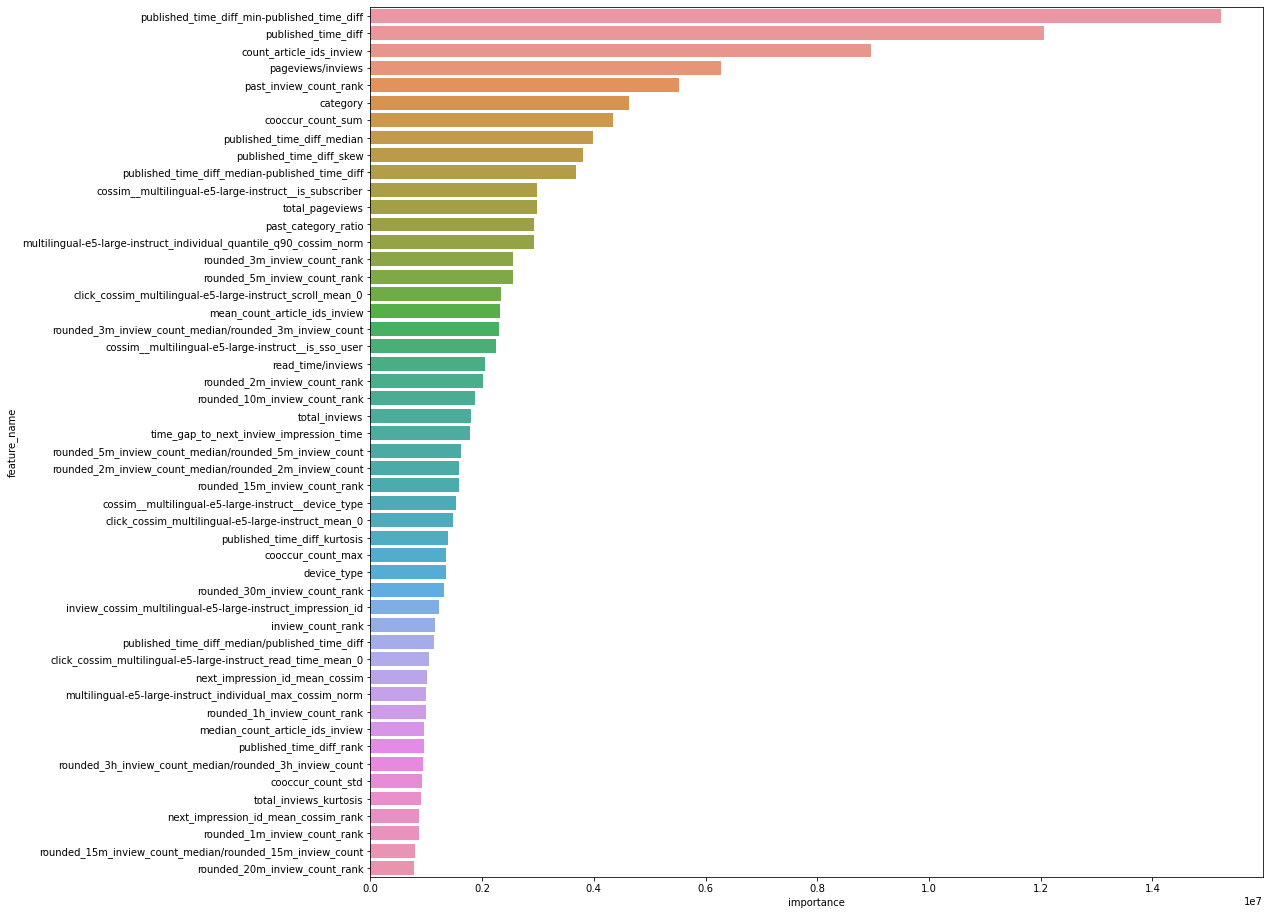

CPU times: user 29d 10h 34min 53s, sys: 44min 55s, total: 29d 11h 19min 48s
Wall time: 20h 23min 38s


In [10]:
%%time
#train
callbacks = [
    lgb.early_stopping(stopping_rounds=1000, verbose=True),
    lgb.log_evaluation(period=100)
]

group_train = imp_train.groupby(imp_train).count().to_numpy()
group_valid = imp_valid.groupby(imp_valid).count().to_numpy()

lgb_train = lgb.Dataset(X_train, label=y_train,group=group_train)
lgb_valid = lgb.Dataset(X_valid, label=y_valid,group=group_valid, reference=lgb_train)

lgb_model = lgb.train(
    lgb_params,
    lgb_train,
    valid_sets=[lgb_valid],
    num_boost_round=30000,
    callbacks=callbacks
)

#best_iter, best_score
best_iter = lgb_model.best_iteration
best_score = lgb_model.best_score['valid_0']['ndcg@5']

logger.info(f'best_iter: {best_iter}, best_score: {best_score}')

#feature importance
feature_importance = lgb_model.feature_importance(importance_type='gain')
feature_name = lgb_model.feature_name()

feature_importance_df = pd.DataFrame({
    'feature_name': feature_name,
    'importance': feature_importance
})

feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

#plot
plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importance_df.head(50), x='importance', y='feature_name')
plt.show()

In [11]:
group_auc = get_mean_auc(lgb_model.predict(X_valid),y_valid,imp_valid)
logger.info(f'group_auc: {group_auc}')

[2024-07-08 10:33:19,477][INFO] group_auc: 0.8577006167802779


In [12]:
X_train.shape

(26658725, 436)